In [1]:
import os
os.environ["PYSPARK_PYTHON"]="C:\\Anaconda3\\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"]="C:\\Anaconda3\\python.exe"

In [2]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [3]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

# (1) DataFrame 생성

In [4]:
irisDf=spark.createDataFrame(iris)

In [5]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



# (2) 회귀선 그래프

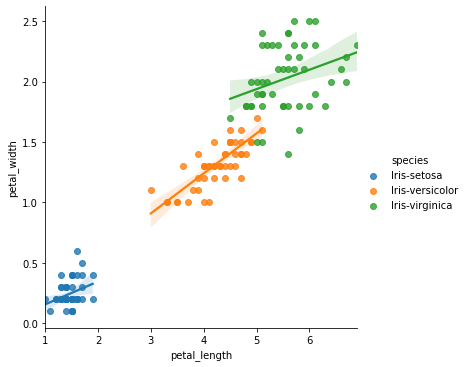

In [6]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris, hue='species')

# (3) Spark를 사용하여 회귀분석하고 계수 출력

In [7]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])

In [8]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["petal_length"], outputCol="features")

In [9]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = "features", labelCol="petal_width")

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[va, lr])

In [11]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [12]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.4211415850785614]
Intercept: -0.371


# (4) 실제와 예측 출력

In [13]:
predictions = model.transform(testDf)

In [14]:
predictions.select('petal_width','prediction').show(5)

+-----------+-------------------+
|petal_width|         prediction|
+-----------+-------------------+
|        0.1|0.09194449847630431|
|        0.3|0.17617281549201658|
|        0.2| 0.2604011325077289|
|        0.2|0.21828697399987274|
|        0.2|0.30251529101558505|
+-----------+-------------------+
only showing top 5 rows



# (5) 정확성 평가하고 출력

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [16]:
f"rmse: {evaluator.evaluate(predictions):.3f}"

'rmse: 0.200'

In [17]:
evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="r2")

In [18]:
f"r2: {evaluator.evaluate(predictions):.3f}"

'r2: 0.931'